In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('data/music_album_reviews.csv')

In [3]:
data.head()

,Review,Rating
0,i think i actually under-rate ok computer if a...,5.0
1,i get why radiohead rub a lot of people the wr...,5.0
2,i would like to think i am good about not lett...,4.5
3,there are radiohead devotees like there were o...,4.0
4,i wrote a shining excellent review for this al...,5.0


In [4]:
data.isnull().sum()

Review      26
Rating    2084
dtype: int64

Кол-во нулей незначительно, так что лучше просто убрать строчки с nan

In [5]:
data = data.dropna() 

<Axes: >

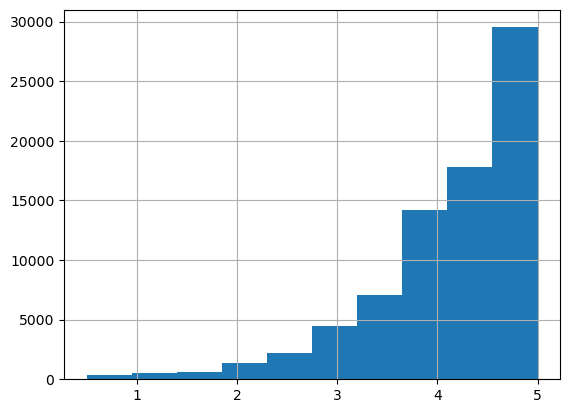

In [6]:
data['Rating'].hist()

Лучше свести к бинарной классификации понравился/не понравился, так как классов слишком много и они слишком несбалансированы, кроме того имеют внутреннюю структуру(5 ближе к 4.5, чем к 1), поэтому считаем, что альбом понравился если рейтинг хотя бы 4 и не понравился иначе.

In [7]:
data['like'] = (data['Rating'] >= 4).astype(int)

### Выбор метрики

Лучше всего выбрать f1_score, так как он учитывает и precision и recall 

In [8]:
from sklearn.metrics import f1_score

In [9]:
import re
def preprocess_text(text):
    return re.sub(r"[^\w\s|]+|[\d]+", '', text).lower()

data['words'] = data['Review'].apply(preprocess_text)
data['words'].head()

0    i think i actually underrate ok computer if an...
1    i get why radiohead rub a lot of people the wr...
2    i would like to think i am good about not lett...
3    there are radiohead devotees like there were o...
4    i wrote a shining excellent review for this al...
Name: words, dtype: object

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def delete_stopwords(words_no_split):
    return ' '.join([word for word in words_no_split.split() if not word in stop_words])

data['no_stopwords'] = data['words'].apply(delete_stopwords)
data['no_stopwords'].head()

0    think actually underrate ok computer anything ...
1    get radiohead rub lot people wrong way lot peo...
2    would like think good letting wider critical w...
3    radiohead devotees like bowie devotees find un...
4    wrote shining excellent review album browser w...
Name: no_stopwords, dtype: object

Применим стеммер и лемматизацию к отзывам без стоп-слов

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import wordnet

In [12]:
lemmatizer = WordNetLemmatizer()

def preprocess_lemmatizer(words):
    return ' '.join([lemmatizer.lemmatize(word) for word in words.split()])

data['text_lemm_no_stopwords'] = data['no_stopwords'].apply(preprocess_lemmatizer)

In [13]:
stemmer = PorterStemmer()

def preprocess_stem(words):
    return ' '.join([stemmer.stem(word) for word in words.split()])

data['text_stemm_no_stopwords'] = data['no_stopwords'].apply(preprocess_stem)

Попробуем применить и сравнить Bag-of-Words со стеммингом и Term Frequency-Inverted Document Frequency с лемматизацией

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data['words'], data['like'], test_size=0.33, random_state=44)
x_stm_nsw_train, x_stm_nsw_test, y_train, y_test = train_test_split(data['text_stemm_no_stopwords'], data['like'], test_size=0.33, random_state=44)
x_lm_nsw_train, x_lm_nsw_test, y_train, y_test = train_test_split(data['text_lemm_no_stopwords'], data['like'], test_size=0.33, random_state=44)

In [16]:
bow = CountVectorizer()
x_words_train_bow = bow.fit_transform(x_train)
x_words_test_bow = bow.transform(x_test)

bow1 = CountVectorizer()
x_stm_nsw_train_bow = bow1.fit_transform(x_stm_nsw_train)
x_stm_nsw_test_bow = bow1.transform(x_stm_nsw_test)

In [17]:
tfidf = TfidfVectorizer()
x_words_train_tfidf = tfidf.fit_transform(x_train)
x_words_test_tfidf = tfidf.transform(x_test)

tfidf1 = TfidfVectorizer()
x_lm_nsw_train_tfidf = tfidf1.fit_transform(x_lm_nsw_train)
x_lm_nsw_test_tfidf = tfidf1.transform(x_lm_nsw_test)

Будем сравнивать LogReg, CatBoost и RandomForest

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

LogReg:

In [19]:
model = LogisticRegression()
model.fit(x_words_train_bow, y_train)
y_pred = model.predict(x_words_test_bow)

f1_score(y_test, y_pred, average='macro')

C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6946369040338238

In [20]:
model = LogisticRegression()
model.fit(x_words_train_tfidf, y_train)
y_pred = model.predict(x_words_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.6856340560946148

In [21]:
model = LogisticRegression()
model.fit(x_stm_nsw_train_bow, y_train)
y_pred = model.predict(x_stm_nsw_test_bow)

f1_score(y_test, y_pred, average='macro')

C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6871100723624302

In [22]:
model = LogisticRegression()
model.fit(x_lm_nsw_train_tfidf, y_train)
y_pred = model.predict(x_lm_nsw_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.6775022319333236

RandomForest:


In [23]:
model = RandomForestClassifier()
model.fit(x_words_train_bow, y_train)
y_pred = model.predict(x_words_test_bow)

f1_score(y_test, y_pred, average='macro')

0.46276873172819155

In [24]:
model = RandomForestClassifier()
model.fit(x_words_train_tfidf, y_train)
y_pred = model.predict(x_words_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.4602373707595443

In [25]:
model = RandomForestClassifier()
model.fit(x_stm_nsw_train_bow, y_train)
y_pred = model.predict(x_stm_nsw_test_bow)

f1_score(y_test, y_pred, average='macro')

0.48353837086798934

In [26]:
model = RandomForestClassifier()
model.fit(x_lm_nsw_train_tfidf, y_train)
y_pred = model.predict(x_lm_nsw_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.47980572535235566

CatBoost:

In [27]:
model = CatBoostClassifier()
model.fit(x_words_train_bow, y_train, verbose=False)
y_pred = model.predict(x_words_test_bow)

f1_score(y_test, y_pred, average='macro')

0.6580603008442876

In [28]:
model = CatBoostClassifier()
model.fit(x_words_train_tfidf, y_train, verbose=False)
y_pred = model.predict(x_words_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.6717453740511808

In [29]:
model = CatBoostClassifier()
model.fit(x_stm_nsw_train_bow, y_train, verbose=False)
y_pred = model.predict(x_stm_nsw_test_bow)

f1_score(y_test, y_pred, average='macro')

0.6448061924669664

In [30]:
model = CatBoostClassifier()
model.fit(x_lm_nsw_train_tfidf, y_train, verbose=False)
y_pred = model.predict(x_lm_nsw_test_tfidf)

f1_score(y_test, y_pred, average='macro')

0.6531069573027088

Видим, что лучше всех отработал логрег, используя метод bag of words. Удаление стоп-слов, лемматизация и стемминг ухудшили не улучшили предсказания


In [31]:
best_model = LogisticRegression()
best_model.fit(x_words_train_bow, y_train)

C:\Users\chesn\miniconda3\envs\ml_py11_torchvision\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Посмотрим 10 самых важных слов для каждого класса

In [32]:
res = dict((v,k) for k,v in bow.vocabulary_.items())
columns = []

In [33]:
for i in range (best_model.coef_[0].shape[0]):
    columns.append(res[i])

In [34]:
coefficients = best_model.coef_[0]

feature_importance = pd.DataFrame({'Feature': columns, 'Weight': coefficients})
feature_importance = feature_importance.sort_values('Weight', ascending=False)
feature_importance[0:10]

,Feature,Weight
116816,perfection,1.382478
53345,essential,1.143701
77147,incredible,1.107387
29256,complex,1.068178
95407,masterpiece,1.066992
162261,timeless,0.981787
59161,five,0.964734
59462,flawless,0.963175
118983,pixies,0.922900
56999,fantastic,0.858763


In [35]:
feature_importance[-1:-11:-1]

,Feature,Weight
37171,decent,-1.929498
168718,unfortunately,-1.691024
96412,mediocre,-1.648940
46472,dull,-1.489307
87138,lacks,-1.422949
12527,awful,-1.380423
41368,difficulty,-1.310832
113451,overrated,-1.266989
178026,worst,-1.216611
18759,boring,-1.192631
